In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna


In [5]:
# Cargar el dataset
data = pd.read_csv('electricity-consumption-processed.csv', sep=';', parse_dates=['datetime'])
data.set_index('datetime', inplace=True)

# Verificar los datos
print(data.head())

                    substation feeder  consumption
datetime                                          
2017-01-01 00:00:00          A     A1    64.671363
2017-01-01 01:00:00          A     A1    58.000000
2017-01-01 02:00:00          A     A1    58.000000
2017-01-01 03:00:00          A     A1    58.000000
2017-01-01 04:00:00          A     A1    52.000000


In [6]:
# Cargar covariantes
covariates = pd.read_csv('meteorological-processed.csv', sep=';', parse_dates=['datetime'])
covariates.set_index('datetime', inplace=True)
# Verificar los datos de las covariantes
print(covariates.head())

                     temperature   humidity  wind_speed    pressure
datetime                                                           
2017-01-01 00:00:00    26.000000  85.000000    9.300000  982.500000
2017-01-01 01:00:00    25.666667  88.000000    8.666667  982.266667
2017-01-01 02:00:00    25.333333  91.000000    8.033333  982.033333
2017-01-01 03:00:00    25.000000  94.000000    7.400000  981.800000
2017-01-01 04:00:00    24.000000  93.333333    9.866667  981.633333


In [7]:
# Filtrar datos por subestación y alimentador, si es necesario
substation = 'A'  # Cambia según tu dataset
feeder = 'A1'      # Cambia según tu dataset
data_filtered = data[(data['substation'] == substation) & (data['feeder'] == feeder)]

In [8]:
# Definir el mes específico que quieres filtrar
start_date = '2019-01-01'
end_date = '2021-12-31'

# Filtrar los datos históricos y las predicciones
data_filtered= data_filtered[start_date:end_date]


In [9]:
# Agrupar por día y calcular el consumo máximo
daily_max_consumption = data_filtered.groupby(data_filtered.index.date)['consumption'].max().reset_index()
daily_max_consumption.columns = ['date', 'max_consumption']
daily_max_consumption.set_index('date', inplace=True)
print(daily_max_consumption)
# Agrupar las covariantes por día, usando la media como ejemplo
daily_covariates = covariates.groupby(covariates.index.date).mean()
daily_covariates.index = pd.to_datetime(daily_covariates.index)
daily_covariates = daily_covariates.reindex(daily_max_consumption.index)
#del daily_covariates['humidity']
print(daily_covariates)


            max_consumption
date                       
2019-01-01        91.000000
2019-01-02       103.000000
2019-01-03        98.000000
2019-01-04        94.247955
2019-01-05        92.000000
...                     ...
2020-12-27              NaN
2020-12-28              NaN
2020-12-29              NaN
2020-12-30              NaN
2020-12-31              NaN

[731 rows x 1 columns]
            temperature   humidity  wind_speed    pressure
date                                                      
2019-01-01    29.525000  70.895833   11.958333  981.243750
2019-01-02    27.733333  82.000000   10.050000  982.591667
2019-01-03    29.116667  75.750000   15.000000  981.291667
2019-01-04    27.412500  80.250000    9.708333  981.454167
2019-01-05    26.283333  80.875000    6.958333  982.137500
...                 ...        ...         ...         ...
2020-12-27    26.683333  69.041667    8.625000  981.779167
2020-12-28    26.375000  79.208333   10.083333  982.033333
2020-12-29    26.33750

In [10]:
# Asegúrate de que ambos DataFrames tienen índices alineados
daily_covariates = daily_covariates.reindex(daily_max_consumption.index)

# Verifica si hay valores nulos después de la alineación
print(daily_covariates.isna().sum())

#Rellena valores nulos si es necesario
daily_covariates = daily_covariates.fillna(method='ffill').fillna(method='bfill')
print(daily_max_consumption)
print(daily_covariates)

temperature    0
humidity       0
wind_speed     0
pressure       0
dtype: int64
            max_consumption
date                       
2019-01-01        91.000000
2019-01-02       103.000000
2019-01-03        98.000000
2019-01-04        94.247955
2019-01-05        92.000000
...                     ...
2020-12-27              NaN
2020-12-28              NaN
2020-12-29              NaN
2020-12-30              NaN
2020-12-31              NaN

[731 rows x 1 columns]
            temperature   humidity  wind_speed    pressure
date                                                      
2019-01-01    29.525000  70.895833   11.958333  981.243750
2019-01-02    27.733333  82.000000   10.050000  982.591667
2019-01-03    29.116667  75.750000   15.000000  981.291667
2019-01-04    27.412500  80.250000    9.708333  981.454167
2019-01-05    26.283333  80.875000    6.958333  982.137500
...                 ...        ...         ...         ...
2020-12-27    26.683333  69.041667    8.625000  981.779167


C:\Users\patri\AppData\Local\Temp\ipykernel_892\2860517806.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_covariates = daily_covariates.fillna(method='ffill').fillna(method='bfill')


In [11]:
# Asegúrate de que ambos DataFrames tienen índices alineados
daily_covariates = daily_covariates.reindex(daily_max_consumption.index)

# Verifica si hay valores nulos después de la alineación
print(daily_covariates.isna().sum())

#Rellena valores nulos si es necesario
daily_covariates = daily_covariates.fillna(method='ffill').fillna(method='bfill')
print(daily_max_consumption)
print(daily_covariates)

temperature    0
humidity       0
wind_speed     0
pressure       0
dtype: int64
            max_consumption
date                       
2019-01-01        91.000000
2019-01-02       103.000000
2019-01-03        98.000000
2019-01-04        94.247955
2019-01-05        92.000000
...                     ...
2020-12-27              NaN
2020-12-28              NaN
2020-12-29              NaN
2020-12-30              NaN
2020-12-31              NaN

[731 rows x 1 columns]
            temperature   humidity  wind_speed    pressure
date                                                      
2019-01-01    29.525000  70.895833   11.958333  981.243750
2019-01-02    27.733333  82.000000   10.050000  982.591667
2019-01-03    29.116667  75.750000   15.000000  981.291667
2019-01-04    27.412500  80.250000    9.708333  981.454167
2019-01-05    26.283333  80.875000    6.958333  982.137500
...                 ...        ...         ...         ...
2020-12-27    26.683333  69.041667    8.625000  981.779167


C:\Users\patri\AppData\Local\Temp\ipykernel_892\2860517806.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_covariates = daily_covariates.fillna(method='ffill').fillna(method='bfill')


In [12]:
# %%
# Asegurarte de que el índice sea de frecuencia diaria

daily_covariates = daily_covariates.dropna()
daily_max_consumption = daily_max_consumption.asfreq('D')
daily_covariates = daily_covariates.asfreq('D')
#Rellena valores nulos si es necesario
daily_max_consumption = daily_max_consumption.fillna(method='ffill').fillna(method='bfill')
print(daily_max_consumption.index.freq)
print(daily_covariates.index.freq) 
print(daily_max_consumption)
print(daily_covariates)

<Day>
<Day>
            max_consumption
date                       
2019-01-01        91.000000
2019-01-02       103.000000
2019-01-03        98.000000
2019-01-04        94.247955
2019-01-05        92.000000
...                     ...
2020-12-27        85.000000
2020-12-28        85.000000
2020-12-29        85.000000
2020-12-30        85.000000
2020-12-31        85.000000

[731 rows x 1 columns]
            temperature   humidity  wind_speed    pressure
date                                                      
2019-01-01    29.525000  70.895833   11.958333  981.243750
2019-01-02    27.733333  82.000000   10.050000  982.591667
2019-01-03    29.116667  75.750000   15.000000  981.291667
2019-01-04    27.412500  80.250000    9.708333  981.454167
2019-01-05    26.283333  80.875000    6.958333  982.137500
...                 ...        ...         ...         ...
2020-12-27    26.683333  69.041667    8.625000  981.779167
2020-12-28    26.375000  79.208333   10.083333  982.033333
2020-12-29

C:\Users\patri\AppData\Local\Temp\ipykernel_892\2144682794.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_max_consumption = daily_max_consumption.fillna(method='ffill').fillna(method='bfill')


In [13]:
# Función objetivo para Optuna
def objective(trial):
    p = trial.suggest_int("p", 0, 10)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 0, 10)
    P = trial.suggest_int("P", 0, 2)
    D = trial.suggest_int("D", 0, 1)
    Q = trial.suggest_int("Q", 0, 2)
    m = trial.suggest_int("m", 7, 30)  # Período estacional entre semanal y mensual

    try:
        # Ajustar el modelo SARIMAX
        model = SARIMAX(
            daily_max_consumption['max_consumption'],
            exog=daily_covariates,
            order=(p, d, q),
            seasonal_order=(P, D, Q, m)
        )
        results = model.fit(disp=False)

        # Realizar predicciones dentro del conjunto de datos
        pred = results.get_prediction(start=daily_max_consumption.index[0], end=daily_max_consumption.index[-1], exog=daily_covariates)
        pred_mean = pred.predicted_mean

        # Calcular el error cuadrático medio
        mse = mean_squared_error(daily_max_consumption['max_consumption'], pred_mean)
        return mse
    except Exception:
        return float('inf')  # Penalizar combinaciones que no funcionen


In [15]:
# Crear un estudio y ejecutar la optimización
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)  # Número de pruebas

# Resultados de la optimización
print("Mejores parámetros:", study.best_params)
print("Mejor MSE:", study.best_value)


[I 2024-11-21 08:47:58,630] A new study created in memory with name: no-name-a0aa0195-01fb-4c0b-a1c5-035a619dcd9e
C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
[I 2024-11-21 08:48:03,917] Trial 0 finished with value: 120.27059393189451 and parameters: {'p': 5, 'd': 1, 'q': 5, 'P': 0, 'D': 0, 'Q': 0, 'm': 28}. Best is trial 0 with value: 120.27059393189451.
C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\patri\AppData\Local\Package

Mejores parámetros: {'p': 7, 'd': 2, 'q': 2, 'P': 1, 'D': 0, 'Q': 1, 'm': 15}
Mejor MSE: 80.5648556143693


In [16]:
# Crea un DataFrame con los resultados de la optimización
results_df = study.trials_dataframe()

# Filtrar el DataFrame para que solo contenga los resultados de MSE
print(results_df.head())
results_df = results_df[['number', 'value','params_D','params_P','params_Q','params_d','params_m','params_p','params_q']]

# Guardar el DataFrame como archivo CSV
results_df.to_csv('optuna_results_mse_only.csv', index=False)

# Imprimir los primeros resultados
print(results_df.head())

   number       value             datetime_start          datetime_complete  \
0       0  120.270594 2024-11-21 08:47:58.632666 2024-11-21 08:48:03.916672   
1       1   85.130853 2024-11-21 08:48:03.918702 2024-11-21 08:48:15.172028   
2       2  195.624702 2024-11-21 08:48:15.173031 2024-11-21 08:48:22.339075   
3       3  567.761096 2024-11-21 08:48:22.340068 2024-11-21 08:49:06.776604   
4       4   86.267257 2024-11-21 08:49:06.778604 2024-11-21 08:49:40.344408   

                duration  params_D  params_P  params_Q  params_d  params_m  \
0 0 days 00:00:05.284006         0         0         0         1        28   
1 0 days 00:00:11.253326         0         0         1         2        19   
2 0 days 00:00:07.166044         0         1         0         0        25   
3 0 days 00:00:44.436536         1         0         1         0        15   
4 0 days 00:00:33.565804         0         0         1         1        29   

   params_p  params_q     state  
0         5         5 

In [17]:
# Usar los mejores parámetros para ajustar el modelo final
best_params = study.best_params
model = SARIMAX(
    daily_max_consumption['max_consumption'],
    exog=daily_covariates,
    order=(best_params['p'], best_params['d'], best_params['q']),
    seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['m'])
)
results = model.fit()



C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\patri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
# %%
# Predicciones
forecast = results.get_prediction(start=daily_max_consumption.index[0], end=daily_max_consumption.index[-1], exog=daily_covariates)
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

In [19]:
# %%
# Calcular métricas finales
mae = mean_absolute_error(daily_max_consumption['max_consumption'], pred_mean)
rmse = np.sqrt(mean_squared_error(daily_max_consumption['max_consumption'], pred_mean))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 6.38, RMSE: 8.98


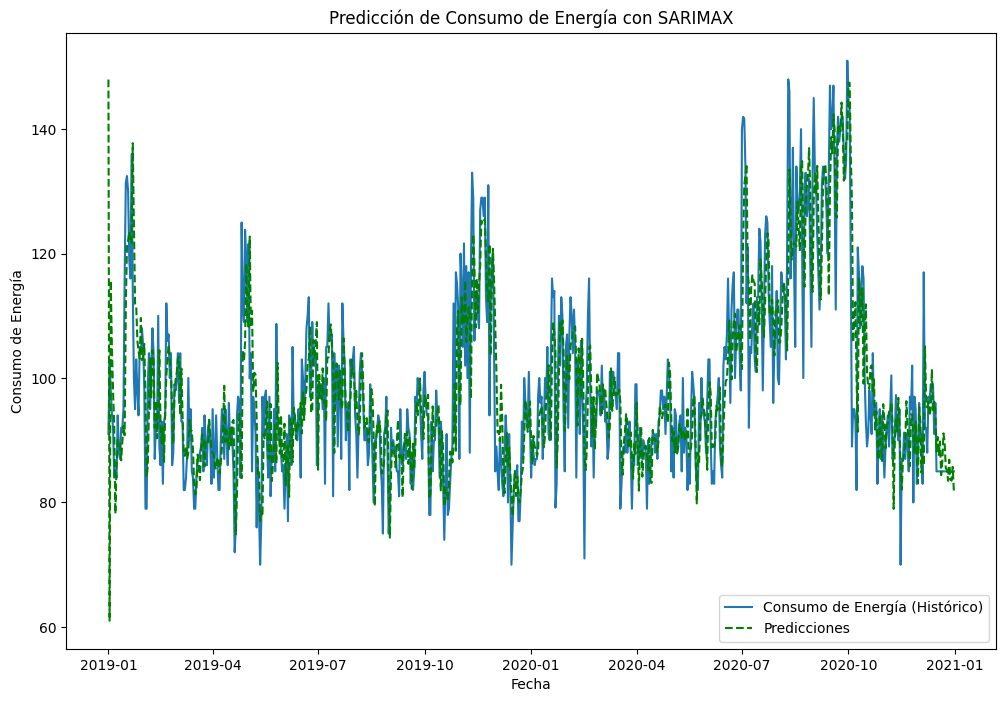

In [20]:

# Graficar
plt.figure(figsize=(12, 8))
plt.plot(daily_max_consumption, label='Consumo de Energía (Histórico)')
plt.plot(pred_mean, color='green', linestyle='--', label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Consumo de Energía')
plt.title('Predicción de Consumo de Energía con SARIMAX')
plt.legend()
plt.show()

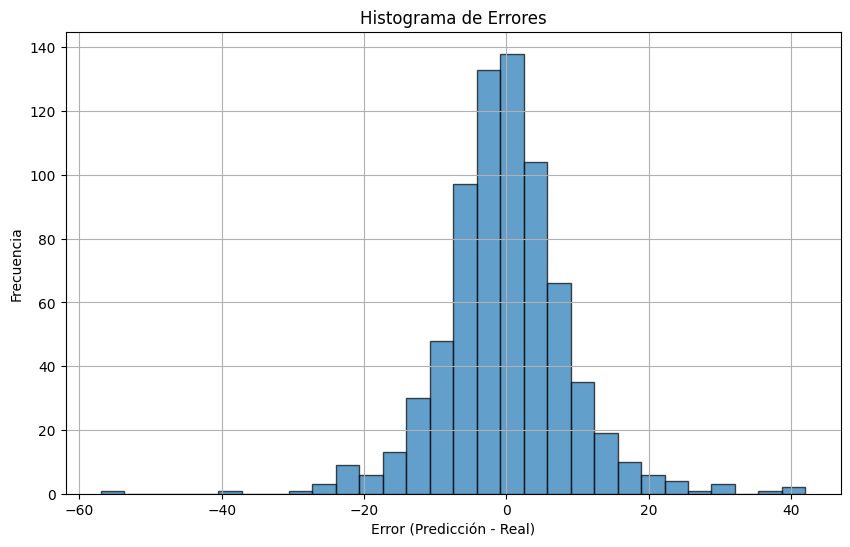

In [21]:
errors = daily_max_consumption['max_consumption'] - pred_mean

# Crear el histograma de los errores
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, edgecolor='black', alpha=0.7)
plt.title('Histograma de Errores')
plt.xlabel('Error (Predicción - Real)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()